<a href="https://colab.research.google.com/github/paolaCaushi/anomalyDetection/blob/logisticRegression/logistiRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load and show dataset**

In [20]:
import pandas as pd

# Load the Excel file
file_path = 'Anomalies_2021_2024.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataset
data.head()


,idAnomalia,idConcentratore,dataAnomalia,latitudine,longitudine,dataCoordinate,dataSegnalazione,note,idPunto
0,18526375,SR013287,2023-05-26 12:16:28,"39,2512","9,1338",2023-05-26 12:16:28,2015-04-22 14:24:01.353,NaN,NaN
1,18699686,SR013287,2023-01-11 13:46:47,"39,2585","9,0723",2023-01-11 13:46:47,2015-06-27 09:05:07.203,NaN,45267.0
2,19367851,SR013279,2022-10-10 08:42:46,"40,124","18,3356",2022-10-10 08:42:46,2015-10-12 09:07:23.653,NaN,42607.0
3,21068660,SR013279,2022-03-26 07:52:15,"41,2507","16,2203",2022-03-26 07:52:15,2016-04-16 09:01:19.923,NaN,40981.0
4,21076623,SR010385,2022-03-28 06:58:52,"44,2287","12,0657",2022-03-28 06:58:52,2016-04-18 07:13:12.357,NaN,NaN


# **Training the model (Logistic Regrression)**

Number of rows (including header): 1608
Number of columns: 9

Sample of the data (first 5 rows):
   idAnomalia idConcentratore        dataAnomalia latitudine longitudine  \
0    18526375        SR013287 2023-05-26 12:16:28    39,2512      9,1338   
1    18699686        SR013287 2023-01-11 13:46:47    39,2585      9,0723   
2    19367851        SR013279 2022-10-10 08:42:46     40,124     18,3356   
3    21068660        SR013279 2022-03-26 07:52:15    41,2507     16,2203   
4    21076623        SR010385 2022-03-28 06:58:52    44,2287     12,0657   

       dataCoordinate        dataSegnalazione note  idPunto  Target  
0 2023-05-26 12:16:28 2015-04-22 14:24:01.353  NaN      NaN       0  
1 2023-01-11 13:46:47 2015-06-27 09:05:07.203  NaN  45267.0       0  
2 2022-10-10 08:42:46 2015-10-12 09:07:23.653  NaN  42607.0       0  
3 2022-03-26 07:52:15 2016-04-16 09:01:19.923  NaN  40981.0       0  
4 2022-03-28 06:58:52 2016-04-18 07:13:12.357  NaN      NaN       0  

Distribution of target va

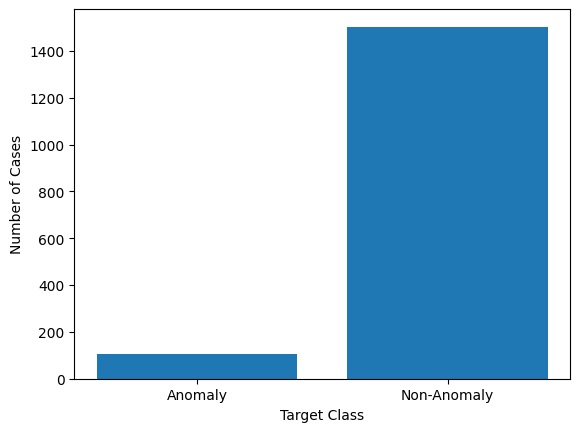

Accuracy: 0.9285714285714286
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       297
           1       0.62      0.20      0.30        25

    accuracy                           0.93       322
   macro avg       0.78      0.59      0.63       322
weighted avg       0.91      0.93      0.91       322



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Specify the path to the Excel file
data_file = "Anomalies_2021_2024.xlsx"

# Read data from Excel into a DataFrame
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Print basic information about the data
print(f"Number of rows (including header): {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Print a sample of the data (first 5 rows)
print("\nSample of the data (first 5 rows):")
print(df.head())

# Print the distribution of the target variable
anomaly_count = df['Target'].sum()
non_anomaly_count = df.shape[0] - anomaly_count
print(f"\nDistribution of target variable:")
print(f"--- Anomaly cases (idPunto NULL and note 12 or 6): {anomaly_count}")
print(f"--- Non-Anomaly cases: {non_anomaly_count}")

# Visualize the distribution with a bar chart
plt.bar(["Anomaly", "Non-Anomaly"], [anomaly_count, non_anomaly_count])
plt.xlabel("Target Class")
plt.ylabel("Number of Cases")
plt.show()

# Drop the 'idPunto' and 'note' columns and convert datetime columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


# **Models metrics**

Confusion Matrix:
[[294   3]
 [ 20   5]]


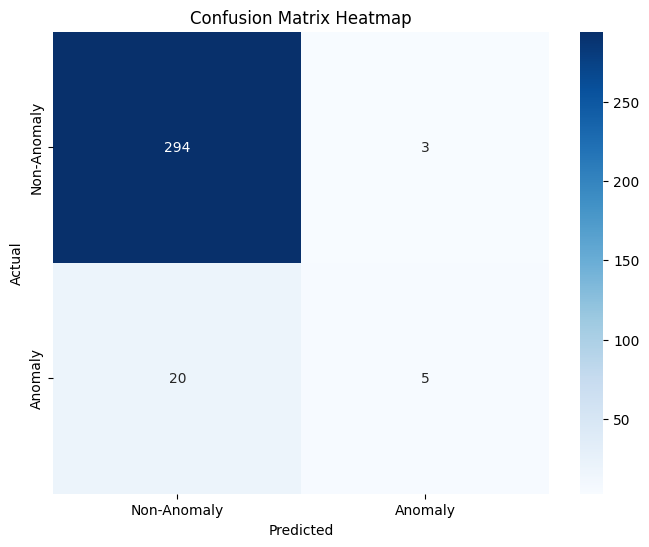

Precision: 0.625
Recall: 0.2
F1 Score: 0.30303030303030304


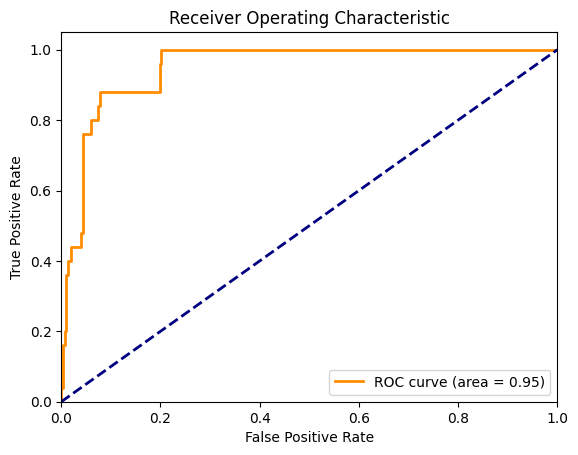

Log Loss: 0.14271906320657404


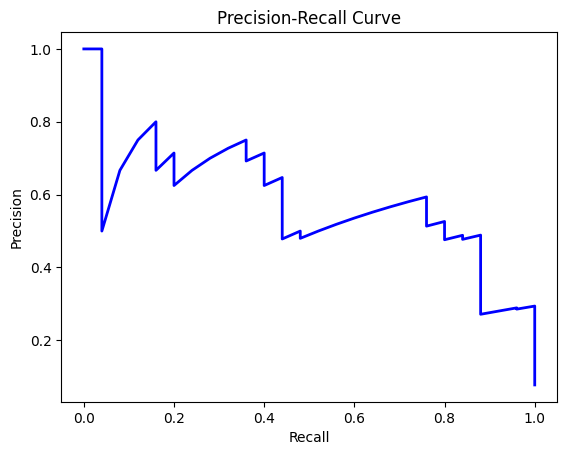

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, log_loss, precision_recall_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Anomaly', 'Anomaly'], yticklabels=['Non-Anomaly', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f'Log Loss: {logloss}')

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall_vals, precision_vals, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# **Additional metrics**

Matthews Correlation Coefficient: 0.3264833711282073
Balanced Accuracy: 0.594949494949495
Brier Score: 0.04278710296387555
Cohen's Kappa: 0.2757676510854684


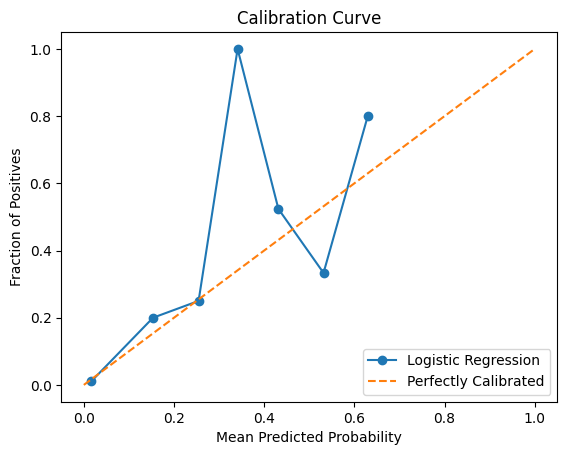

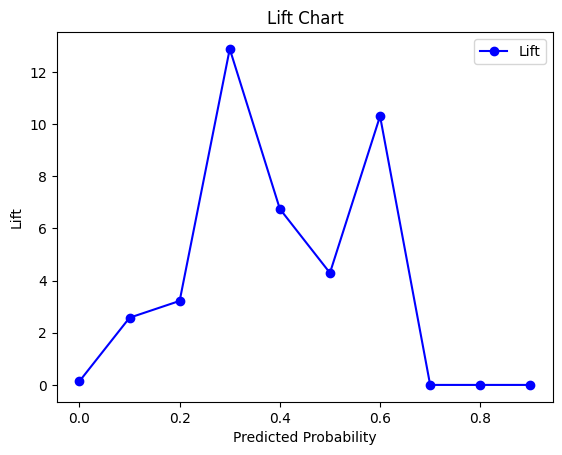

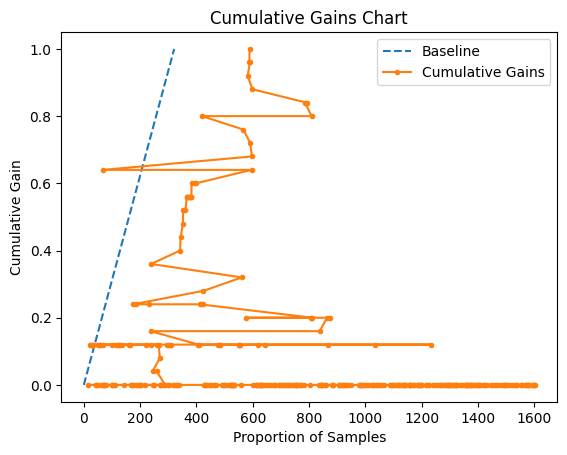

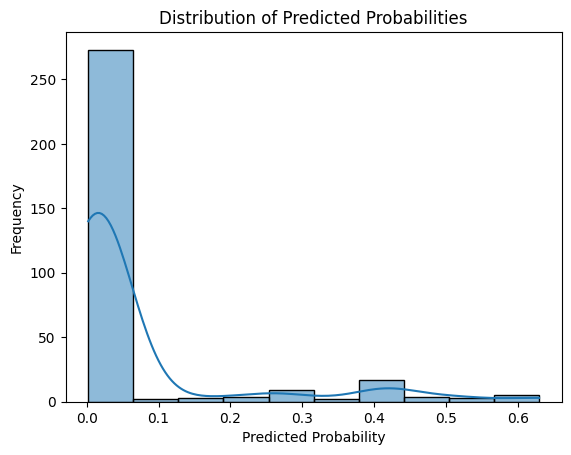

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, log_loss, precision_recall_curve, matthews_corrcoef, balanced_accuracy_score, brier_score_loss, cohen_kappa_score
from sklearn.calibration import calibration_curve


# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f'Matthews Correlation Coefficient: {mcc}')

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_acc}')

# Brier Score
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f'Brier Score: {brier_score}')

# Cohen's Kappa
cohen_kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {cohen_kappa}")

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# Lift Chart
# Create bins for lift chart
bins = np.linspace(0, 1, 11)
binned = np.digitize(y_pred_proba, bins) - 1
lift = [np.mean(y_test[binned == i]) / np.mean(y_test) if np.sum(binned == i) > 0 else 0 for i in range(len(bins)-1)]
plt.figure()
plt.plot(bins[:-1], lift, marker='o', color='b', label='Lift')
plt.xlabel('Predicted Probability')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend()
plt.show()


# Cumulative Gains Chart
sorted_indices = np.argsort(y_pred_proba)
sorted_y_test = y_test.iloc[sorted_indices]
cumulative_gain = np.cumsum(sorted_y_test) / np.sum(sorted_y_test)
baseline = np.linspace(0, 1, len(cumulative_gain))
plt.figure()
plt.plot(baseline, linestyle='--', label='Baseline')
plt.plot(cumulative_gain, marker='.', label='Cumulative Gains')
plt.xlabel('Proportion of Samples')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gains Chart')
plt.legend()
plt.show()

# Distribution of Predicted Probabilities
plt.figure()
sns.histplot(y_pred_proba, bins=10, kde=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()
